# Priestley-Taylor PET calculations

**Last Updated: August 17, 2018**

**Emma Collins**

In this notebook we will calculate PET for Congaree National Park area using Priestly-Taylor equations (1972); thus, the potential evapotranspiration will be guided by the following: 

$$\begin{equation}
PET = \alpha * \frac{\Delta}{\Delta +\gamma}(R_n-G)
\end{equation}$$

where $\Delta$ is the slope of saturation vapor pressure curve at air temperature $T$, $\gamma$ is the psychrometric constant, $R_n$ is net radiation, $G$ si the heat flux transfer to and from the soil, and $\alpha$ is a saturation deficit term.

We will utilize weather station and solar radiation data from the following sources:
- Weather Station:
    - Remote Automated Weather Station (RAWS)
    - Site Name: Congaree
    - Site Code: SCON
    - Station ID: GDNS1
    - Watershed HUC8 : 03050110
    - Lat/Long: 33˚48'54"N, 80˚46'52"W
    - Elevation: 123 ft
- National Solar Radiation Database
    

In [1]:
import numpy as np
import pandas as pd
import PriestlyTaylorET as PT
import MesoWestAPI as mwAPI
import NSRDBAPI as solradAPI

## Loading the Data

First, we need all data inputs necessary for PET calculations. 

### Extraterrestrial Solar Radiation Data download

Using the NREL National Solar Radiation Database API. Note: this code is dependent on the `NSRDBAPI.py` module. See module for specific code

We will save the extraterrestrial solar radiation in a dataframe. I've selected GHI as the parameter to download from the database. GHI stands for Global Horizontal Irradiance, which is defined as:
- "the total amount of shortwave radiation received from above by a horizontal surface. This value is of particular interest to photovoltaic installations and includes both Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DIF)." (https://www.3tier.com/en/support/glossary/#ghi)

In [2]:
#Attributes to download from NSRDB
attributes = 'ghi'

#Latitude and Longitude of area of interest
lat, lon = 33.814722, -80.781111

#Year of interest
year = '2009'

#Specific Start and End date of interest
start_time = '2009-6-1'
end_time = '2009-7-31'

#Access the API
metadata, GHI_df = solradAPI.access_NSRDB(lat, lon, year, attributes)
GHI_df = solradAPI.subset_NSRDB_df(GHI_df, start_time, end_time, preview = False)
print(GHI_df)

# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = metadata['Local Time Zone'], metadata['Elevation']
print('\n--------------------\n\nTimezone (hrs to UTC):', timezone[0])
print('\n\nElevation (m):', elevation[0])


                DateTime  Year  Month  Day  Hour  Minute  GHI
0    2009-06-01 00:00:00  2009      6    1     0      30    0
1    2009-06-01 01:00:00  2009      6    1     1      30    0
2    2009-06-01 02:00:00  2009      6    1     2      30    0
3    2009-06-01 03:00:00  2009      6    1     3      30    0
4    2009-06-01 04:00:00  2009      6    1     4      30    0
5    2009-06-01 05:00:00  2009      6    1     5      30   14
6    2009-06-01 06:00:00  2009      6    1     6      30  167
7    2009-06-01 07:00:00  2009      6    1     7      30  364
8    2009-06-01 08:00:00  2009      6    1     8      30  562
9    2009-06-01 09:00:00  2009      6    1     9      30  735
10   2009-06-01 10:00:00  2009      6    1    10      30  868
11   2009-06-01 11:00:00  2009      6    1    11      30  948
12   2009-06-01 12:00:00  2009      6    1    12      30  969
13   2009-06-01 13:00:00  2009      6    1    13      30  695
14   2009-06-01 14:00:00  2009      6    1    14      30  832
15   200

## Accessing Weather Station Data

Using MesoWest API for Congaree Weather Station GDNS1. Note: this code is dependent on `MesoWestAPI.py` module to work, and `access_mesoWest()` has more optional inputs. For convenience the station and parameters of interest have been set as the default.

In [3]:
#Define the period of interest in the format yyyymmddHHMM
start_time = '200906010400'
end_time = '200908010400'

#This function returns a JSON object containing the desired weather station data
weather = mwAPI.access_mesoWest(start_time, end_time)

In [4]:
#Store observations as numpy arrays, note observations are hourly
date_time = np.array(weather['STATION'][0]['OBSERVATIONS']['date_time'])
solar_radiation = np.array(weather['STATION'][0]['OBSERVATIONS']['solar_radiation_set_1'])
fuel_temp = np.array(weather['STATION'][0]['OBSERVATIONS']['fuel_temp_set_1'])
relative_humidity = np.array(weather['STATION'][0]['OBSERVATIONS']['relative_humidity_set_1'])
fuel_moisture = np.array(weather['STATION'][0]['OBSERVATIONS']['fuel_moisture_set_1'])
air_temp = np.array(weather['STATION'][0]['OBSERVATIONS']['air_temp_set_1'])
precip_accum = np.array(weather['STATION'][0]['OBSERVATIONS']['precip_accumulated_set_1d'])

### Missing Data

To handle the missing data issue, we will ensure that we only keep weather station and solar radiation data points when both are available.

Note: This is the largest computational cost of the program, and discards potentially many data points. Should we use interpolation methods to fill in missing data? 

In [5]:
GHI_ind = []
weather_ind = []
for i in range(len(GHI_df.iloc[:,0])):
    for j in range(len(date_time)):
        if np.datetime64(GHI_df.iloc[i,0])== np.datetime64(date_time[j][0:13]):
            if relative_humidity[j] and solar_radiation[j] and fuel_temp[j] and fuel_moisture[j] and air_temp[j] and precip_accum[j]:
                GHI_ind.append(i)
                weather_ind.append(j)

Here I aggregate GHI by sum to get a daily value.

In [6]:
GHI_daily = GHI_df.iloc[GHI_ind].groupby(['Year','Month', 'Day']).agg({'GHI':'sum'})
GHI_daily.head()

GHI
Year Month Day      
2009 6     10   2043
           11   3696
           12   6130
           13   6766
           14   6505

In [7]:
date_time = date_time[weather_ind]
solar_radiation = solar_radiation[weather_ind]
fuel_temp = fuel_temp[weather_ind]
relative_humidity = relative_humidity[weather_ind]
fuel_moisture = fuel_moisture[weather_ind]
air_temp = air_temp[weather_ind]

### Aggregating Weather Station to Daily Values

In [8]:
weather_station = pd.DataFrame(weather['STATION'][0]['OBSERVATIONS'])
weather_station['date_time'] = pd.to_datetime(weather_station['date_time'], format = '%Y-%m-%d %H:%M')
weather_station['date_time'] = weather_station['date_time'].dt.floor('d')
weather_station_daily = weather_station.groupby(['date_time']).agg({'air_temp_set_1':'mean','fuel_moisture_set_1':'mean', 'fuel_temp_set_1':'mean', 'relative_humidity_set_1':'mean', 'solar_radiation_set_1':'sum'})
weather_station_daily = weather_station_daily.dropna(how = 'any')
weather_station_daily.head()


,air_temp_set_1,fuel_moisture_set_1,fuel_temp_set_1,relative_humidity_set_1,solar_radiation_set_1
date_time,,,,,
2009-06-10,24.977500,20.183333,26.481250,78.818182,5494.0
2009-06-11,23.797083,21.916667,25.255417,84.157895,4829.0
2009-06-12,24.258750,22.470833,25.623750,87.166667,4902.0
2009-06-13,25.810417,18.954167,27.570000,82.208333,5667.0
2009-06-14,26.064167,16.883333,28.264583,80.125000,5484.0


### Converting from Solar Radiation To Net Radiation

Albedo is manually set at 0.15, which is an estimate for coniferous/decidious forests (http://www.climatedata.info/forcing/albedo/).

$a_c$, $b_c$ (FAO 1990)

In [9]:
#For a coniferous/deciduous forest, albedo is set at 0.15
albedo = 0.15

#extraterrestrial solar radiation
Ra = np.asarray(GHI_daily)

#Convert from W/m**2 to MJ/m**2/d
Ra = Ra*0.0864
solar_radiation = np.asarray(weather_station_daily['solar_radiation_set_1'])
solar_radiation = solar_radiation*0.0864

#Elevation of weather station(m)
elevation_ft = np.float(weather['STATION'][0]['ELEVATION'])
elevation = elevation_ft*.3048

#Daily Air Temp
air_temp_daily = np.asarray(weather_station_daily['air_temp_set_1'])

#Daily Relative Humidity
relative_humidity_daily = np.asarray(weather_station_daily['relative_humidity_set_1'])

#Daily Fuel Temp
fuel_temp_daily = np.asarray(weather_station_daily['fuel_temp_set_1'])

#Daily Fuel Moisture
fuel_moisture_daily = np.asarray(weather_station_daily['fuel_moisture_set_1'])

### Priestley-Taylor PET calculations

Implementing Priestly Taylor for Congaree NP

In [10]:
evapotranspiration = PT.PET(air_temp_daily, fuel_temp_daily, elevation,relative_humidity_daily, fuel_moisture_daily, solar_radiation, Ra, albedo)

#convert from MJ/m**2/day to mm/day
evapotranspiration = evapotranspiration/2.45


## Data Visualization

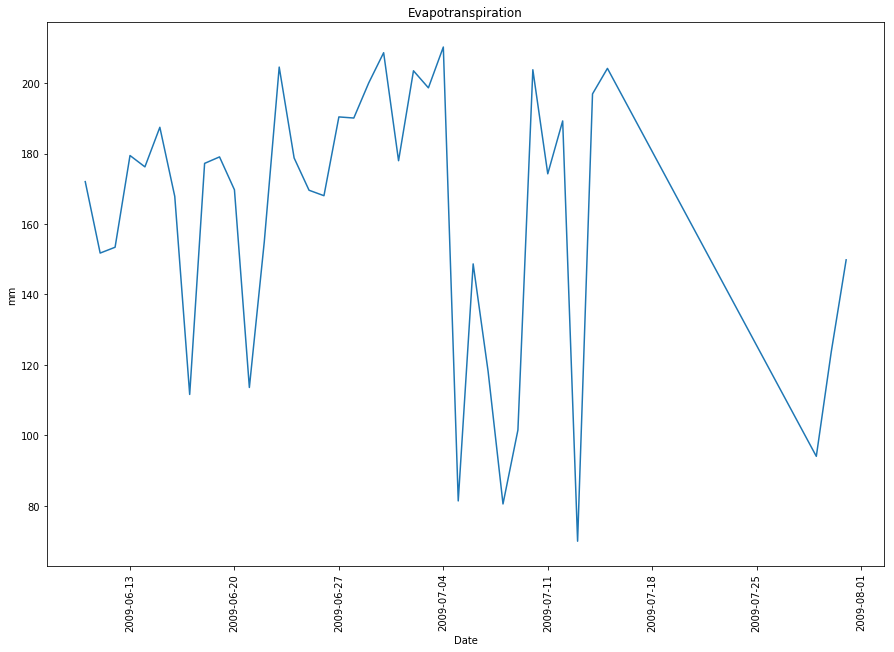

In [11]:
dates = PT.graph_ET_results(date_time, evapotranspiration)

### Results:

The final product of the calculations, a table of PET in mm by day. 

In [12]:
ET = pd.DataFrame(evapotranspiration, columns = {'PET (mm)'})
date = pd.DataFrame(dates, columns = {'Date'})
table = pd.concat([date, ET], axis=1)
print(table)

          Date    PET (mm)
0   2009-06-10  172.027980
1   2009-06-11  151.739771
2   2009-06-12  153.393715
3   2009-06-13  179.441445
4   2009-06-14  176.220550
5   2009-06-15  187.459973
6   2009-06-16  167.836115
7   2009-06-17  111.596687
8   2009-06-18  177.207333
9   2009-06-19  179.047043
10  2009-06-20  169.707196
11  2009-06-21  113.573831
12  2009-06-22  154.941933
13  2009-06-23  204.549766
14  2009-06-24  178.752090
15  2009-06-25  169.581915
16  2009-06-26  168.029172
17  2009-06-27  190.401913
18  2009-06-28  190.088410
19  2009-06-29  200.053239
20  2009-06-30  208.634059
21  2009-07-01  177.967797
22  2009-07-02  203.501956
23  2009-07-03  198.658479
24  2009-07-04  210.245503
25  2009-07-05   81.360230
26  2009-07-06  148.665686
27  2009-07-07  118.197137
28  2009-07-08   80.500184
29  2009-07-09  101.497511
30  2009-07-10  203.796999
31  2009-07-11  174.246568
32  2009-07-12  189.260929
33  2009-07-13   69.918777
34  2009-07-14  196.933903
35  2009-07-15  204.185001
3

## Questions:

- I used the GHI parameter from the NSRDB as an estimate for extraterrestrial solar radiation, could I improve upon this?
    - **Extraterrestrial Solar Radiation:** the intensity (power) of the sun at the top of the Earth's atmosphere. It is usually expressed in irradiance units (Watts per square meter) on a plane normal to the sun
    - **Global Horizontal Irradiance (GHI):** the total amount of shortwave radiation received from above by a surface horizontal to the ground.
- There is certainly a more scientifically and computationally efficient way to handle missing data from the NSRDB and weather station. What interpolation methods could be applied to fill in missing data, or how can I speed up the process of discarding incomplete data points?